### IMPORT BIBLIOTEK

In [1]:
import os
import json
import string
import morfeusz2
import numpy as np
import pandas as pd
import itertools as it
import operator as op

from wordcloud import WordCloud
from matplotlib import pyplot as plt 
from nltk.util import ngrams
from nltk.corpus import PlaintextCorpusReader
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from nltk.tokenize import word_tokenize
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

1. Utworzenie korpusu dokumentów

In [2]:
corpus_dir = "./my_literatura"
corpus = PlaintextCorpusReader(corpus_dir, ".*\.txt")
files = corpus.fileids()
files

['Akademia Policyjna 1.txt',
 'Akademia Policyjna 2 Pierwsze zadanie.txt',
 'Akademia Policyjna 3 Powrót do szkoły.txt',
 'Akademia Policyjna 4 Patrol obywatelski .txt',
 'Akademia Policyjna 5 Misja w Miami Beach.txt',
 'Akademia Policyjna 6 Operacja Chaos.txt',
 'Akademia Policyjna 7 Misja w Moskwie.txt',
 'Jak rozpętałem II wojnę światową 1 Ucieczka.txt',
 'Jak rozpętałem II wojnę światową 2 Za bronią.txt',
 'Jak rozpętałem II wojnę światową 3 Wśród swoich.txt',
 'Piraci z Karaibów 1 Klątwa Czarnej Perły.txt',
 'Piraci z Karaibów 2 Skrzynia umarlaka.txt',
 'Piraci z Karaibów 3 Na krańcu świata.txt',
 'Piraci z Karaibów 4 Na nieznanych wodach.txt',
 'Piraci z Karaibów 5 Zemsta Salazara.txt',
 'Szklana Pułapka 1.txt',
 'Szklana Pułapka 2.txt',
 'Szklana Pułapka 3.txt',
 'Szklana Pułapka 4.txt',
 'Szklana Pułapka 5.txt']

Tworzymy korpus dokumentów na podsatwie dołączonych plików wskazanych w śceiżce jako katalog -> 'my_literatura'

Katalog zawiera 20 przygotowanych we włąsanym zakresie plików .txt z 4 różnych tematyk

2. wstepne przygotowwanie dokumentów

In [3]:
documents = {}
for f in files:
    documents[f] = corpus.raw(f)
print(json.dumps(documents, indent=4, ensure_ascii=False))

{
    "Akademia Policyjna 1.txt": "W odpowiedzi na brak kandydatów do policji, burmistrz ogłasza, że do akademii może zgłosić się każdy obywatel, bez względu na wygląd, płeć czy wykształcenie. To wywołuje chaos, gdyż przybywają najbardziej niedopasowani i niezdarni rekruci. Wśród nich jest Carey Mahoney – uliczny cwaniak, który trafia do akademii w ramach kary sądowej. Wraz z nim pojawiają się m.in. Hightower, ogromny, ale łagodny mężczyzna, Tackleberry – maniak broni palnej, oraz Larvell Jones, znany z doskonałych imitacji dźwięków.Szefem akademii jest komendant Eric Lassard, który postanawia dać każdemu szansę, mimo protestów sierżanta Harrisa, który robi wszystko, by pozbyć się niechcianych kadetów. Przez cały okres szkolenia rekruci mierzą się z własnymi słabościami, ale także z surowymi instruktorami. Gdy w mieście wybuchają zamieszki, tylko nowicjusze z akademii są gotowi działać. Dzięki odwadze, sprytowi i niekonwencjonalnemu podejściu udaje im się zaprowadzić porządek. Film koń

Przetwarzamy w/w korpus na inny format danych, w tym przypadku na swego rodzaju słownik, gdzie kluczami są nazwy plików natomist warościami zawartość tekstowa każdego dokumentu czyli 'surowy'tekst'

In [4]:
stoplist_file = open("./stopwords_pl.txt", "r", encoding="UTF-8")
stoplist = stoplist_file.read().splitlines()
stoplist_file.close()
stoplist

['# This file was created from the carrot2 project and is distributed under the BSD license.',
 '# See http://project.carrot2.org/license.html',
 '# Also see http://www.opensource.org/licenses/bsd-license.html',
 '# From trunk/core/carrot2-util-text/src-resources/stopwords.pl',
 'vol',
 'o.o.',
 'mgr',
 'godz',
 'zł',
 'www',
 'pl',
 'ul',
 'tel',
 'hab',
 'prof',
 'inż',
 'dr',
 'i',
 'u',
 'aby',
 'albo',
 'ale',
 'ani',
 'aż',
 'bardzo',
 'bez',
 'bo',
 'bowiem',
 'by',
 'byli',
 'bym',
 'był',
 'była',
 'było',
 'były',
 'być',
 'będzie',
 'będą',
 'chce',
 'choć',
 'co',
 'coraz',
 'coś',
 'czy',
 'czyli',
 'często',
 'dla',
 'do',
 'gdy',
 'gdyby',
 'gdyż',
 'gdzie',
 'go',
 'ich',
 'im',
 'inne',
 'iż',
 'ja',
 'jak',
 'jakie',
 'jako',
 'je',
 'jednak',
 'jednym',
 'jedynie',
 'jego',
 'jej',
 'jest',
 'jeszcze',
 'jeśli',
 'jeżeli',
 'już',
 'ją',
 'kiedy',
 'kilku',
 'kto',
 'która',
 'które',
 'którego',
 'której',
 'który',
 'których',
 'którym',
 'którzy',
 'lat',
 'lecz',

Odczytujemy plik zawierajacy 'stop-liste' czyli zestaw słów nieistotnych z punktu widzenia znaczenia sematycznego

In [5]:
def lematize(text):
    morf = morfeusz2.Morfeusz()
    segments = it.groupby(morf.analyse(text), op.itemgetter(0,1))
    def disambiguate(group):
        pairs = ((len(descr), lemma)
            for _, _, (_, lemma, descr, _, _,) in group)
        perpl, lemma = min(pairs)
        return lemma.split(":")[0]
    lemmas = (disambiguate(group) for key, group in segments)
    return " ".join(filter(str.isalpha, lemmas))

Definicja funkcji do leamtyzacji

In [6]:
for key in documents:
    documents[key] = documents[key].lower()
    documents[key] = "".join(char for char in documents[key] if char not in string.punctuation)
    documents[key] = lematize(documents[key])
    documents[key] = " ".join([word for word in word_tokenize(documents[key], language="polish") if word not in stoplist])
print(json.dumps(documents, indent=4, ensure_ascii=False))

{
    "Akademia Policyjna 1.txt": "odpowiedź brak kandydat policja burmistrz ogłaszać akademia zgłosić każdy obywatel wzgląd wygląd płeć wykształcić wywoływać chaos przybywać dopasować niezdarny rekrut carey mahoney uliczny cwaniak trafiać akademia rama kara sądowy wraz pojawiać minuta hightower ogromny łagodny mężczyzna tackleberry maniak broń palny larvell Jones znany doskonały imitacja dźwiękówszefem akademia komendant eric lassard postanawiać dać każdy szansa protest sierżant harrisa robić pozbyć chcieć kadet cały okres szkolenie rekrut mierzyć własne słabość surowy instruktor miesić wybuchać zamieszka nowicjusz akademia got działać dzięki odwaga spryt niekonwencjonalny podejście udawać zaprowadzić porządek film kończyć scena uroczysty promocja mahoney przyjaciel zostawać pełnoprawny policjant ku niezadowolenie harrisa",
    "Akademia Policyjna 2 Pierwsze zadanie.txt": "świeżo upiec absolwent akademia policyjny zostawać przydzielić praca różny jednostka mahoney hightower tackleberr

Proces lematyzacji, w wyniku którego otrzymujemy:
- korpus w postaci słownika po wstępnym przetworzeniu, gdzie kluczem jest nazwa pliku a wartością jego zawartość
- zmiana tekstu na małe litery (warto zauważyć że po lematyzacji część słów pozostaje z dużej litery np. 'Franka', 'Jack', 'Miami', 'Jugosławia' tam gdzie w procesie lematyzacji rozpoznane zostały nazwy własne)
- usunięte znaki interpunkcyjne '?', '.', '!' nieistotne z punktu widzenia algorytmu
- tokenizacje czyli podział na słowa + usunięcie tzw. stopwords — czyli najczęstszych słów, które nie wnoszą wartości semantycznej

3. Utowrzenie macierzy czestosci

In [7]:
docs = pd.DataFrame.from_dict(documents, orient='index')
docs.columns= ['content']
docs

,content
Akademia Policyjna 1.txt,odpowiedź brak kandydat policja burmistrz ogła...
Akademia Policyjna 2 Pierwsze zadanie.txt,świeżo upiec absolwent akademia policyjny zost...
Akademia Policyjna 3 Powrót do szkoły.txt,władza decydować miesić pozostać jednać akadem...
Akademia Policyjna 4 Patrol obywatelski .txt,komendant lassard inicjować nowy program obywa...
Akademia Policyjna 5 Misja w Miami Beach.txt,komendant lassard zostawać uhonorować policjan...
Akademia Policyjna 6 Operacja Chaos.txt,miasto ogarniać fala przestępczość sterować ta...
Akademia Policyjna 7 Misja w Moskwie.txt,razem drużyna akademia policyjny wyruszać gran...
Jak rozpętałem II wojnę światową 1 Ucieczka.txt,film rozpoczynać wrzesień rok wybuchać wojna ś...
Jak rozpętałem II wojnę światową 2 Za bronią.txt,Franka dolas ucieczka obóz jeniecki kontynuowa...
Jak rozpętałem II wojnę światową 3 Wśród swoich.txt,trzecia część saga frank dolasie rozpoczynać b...


Wykonujemy przekszatałecenie na podstawie zawartości słownika, w wyniku którego otrzymujemy:
- index jako klucz słownika czyli nazwy plików
- content jako wartość czyli zawartość (przetworzona) plików

In [8]:
count_vectorizer = CountVectorizer()
counts_tf = count_vectorizer.fit_transform(docs['content'])
counts_tf.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], shape=(20, 1149))

Tworzymy macierz częstości 'counts_tf', którą nastepnie przetwarzamy z macierzy rzadkiej do postaci  'klasycznej' w celu jej zaprezentowania.

Macierz ta daje nam informację ile razy dane słowo wystąpiło w danym dokumencie, gdzie wiersz = dokument a kolumny = słowa(unikalne w korpusie)

In [9]:
tfidf_vectorizer = TfidfVectorizer()
counts_tfidf = tfidf_vectorizer.fit_transform(docs['content'])
counts_tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.12227802, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.10156487, ..., 0.        , 0.        ,
        0.        ]], shape=(20, 1149))

Tworzymy macierz tfdf czyli Term Frequency - Inverse Document Frequency, gdzie wiersz = dokument (20) a każda kolumna = unikatowe słowo (1149) 

Macierz waży słowa nie tylko pod kątem ich częstości występowania w danym dokumencie ale też na podstawie ich unikatowości w całym korpusie.
W efekcie :
- Jeśli słowo jest bardzo częste w jednym dokumencie i rzadkie w innych -> będzie miało wysoki współczynnik TF-IDF
- Jeśli słowo jest bardzo częste we wszystkich dokumentach -> jego TF-IDF będzie bliski zeru

4. Chmury tagów

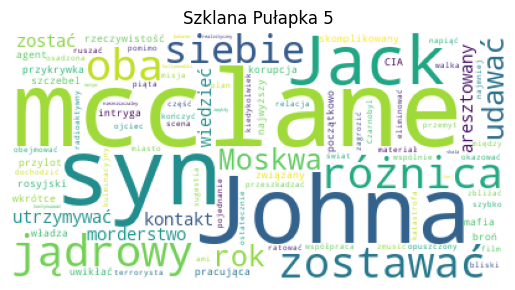

In [10]:
wordcloud = WordCloud(
    background_color ='white',
    max_words=5000,
    contour_width=3,
    contour_color='steelblue'
)
if not os.path.exists("./chmury"):
    os.mkdir("./chmury")
for index, row in docs.iterrows():
    wordcloud.generate(row['content'])
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(index.replace(".txt", ""))
    plt.savefig("./chmury/{}".format(index.replace(".txt", ".png")))


    

W tej sekcji generujemy 'chmurę słów' dedykowana dla każdego dokumentu. Wynik zapisujemy w katalogu './chmury'.

Chmura słów pełni rolę wizualizacji gdzie większe słowa wskazują na częsciej wstępujące w danym dokumencie (czyli wielkośc słów jest proporcjonalna do częstotliowści występowania). Przykładowo mclane, John, syn, Jack ->  główne postacie 'Szkalana pułapka 5' co dobrze oddaje temat filmu.
Analiza chmury słów dla poszczególnych dokumentów pokazała, że model prawidłowo identyfikuje słowa kluczowe dla danej fabuły.
Jednak należy zauważyć, że opieranie się wyłącznie na pojedynczych słowach (czy ich częstości) może prowadzić do niejednoznacznych rezultatów przy próbie klasyfikacji dokumentów według źródła (serii). Wiele terminów ogólnych, związanych np. z motywami akcji, relacji rodzinnych czy walki, powtarza się w różnych seriach, co utrudnia ich jednoznaczne przypisanie.

5. Topic modelling

In [11]:
if not os.path.exists("./tematy"):
    os.mkdir("./tematy")

In [12]:
def plot_top_words(model, feature_names, n_top_words, title, subplots):
    fig, axes = plt.subplots(*subplots, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[-n_top_words:]
        top_features = feature_names[top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.savefig(f"./tematy/{title}.png")
    plt.close()


Definicja funkcji plot_top_words, która wizualizuje tematy wygenerowane przez model (np. LDA lub NMF...).
Dla każdego tematu rysuje wykres słupkowy przedstawiający n_top_words słów najbardziej charakterystycznych dla danego tematu wraz z ich wagami. Wygenerowane wykresy są zapisywane do katalogu ./tematy jako pliki PNG.

In [13]:
def plot_documents(model, counts, files_names, n_components, title):
  colors = ['forestgreen', 'lightskyblue', 'hotpink', 'turquoise', 'steelblue', 'crimson', 'seagreen', 'orange']
  docs_topics = pd.DataFrame(model.transform(counts), columns=[f"Topic {x}" for x in range(n_components)])
  docs_topics.index = [file_name.replace(".txt", "") for file_name in files_names]
  plt.figure(figsize=(7,4))
  left = [0] * len(docs_topics)
  for i, col in enumerate(docs_topics.columns):
    plt.barh(docs_topics.index, docs_topics[col], left=left, label=col, color = colors[i])
    left = [left[j]+docs_topics[col].iloc[j] for j in range(len(docs_topics))]
  plt.gcf().subplots_adjust(left=0.51)
  plt.savefig(f"./tematy/{title}_docs.png")
  plt.close()

Definicja funkcji plot_documents, która wizualizuje udział tematów w poszczególnych dokumentach w postaci wykresu słupkowego. Każdy poziomy słupek reprezentuje jeden dokument, a segmenty słupka pokazują udział poszczególnych tematów. Wygenerowany wykres jest zapisywany do katalogu ./tematy jako plik _DOCS.PNG

In [14]:
n_components = 4
feature_names = count_vectorizer.get_feature_names_out()
n_top_words = 20
subplots = (1,4)

Propozycja podziału na 4 tematyki oraz 20 topowych słów. Warto zaznaczyć, iż jest to metoda nienadzorowana więc 'narzucamy' ile tych tematyk  mogło by być

In [15]:
lda = LatentDirichletAllocation(
    n_components =n_components,
    max_iter=5,
    learning_method='online',
    learning_offset=50,
    random_state=0
)
lda.fit(counts_tf)
plot_top_words(lda, feature_names, n_top_words, "Tematy w modelu LDA", subplots)
plot_documents(lda, counts_tf, files, n_components, "Tematy w modelu LDA")

Budujemy model LDA (Latent Dirichlet Allocation), który próbuje odkryć ukryte tematy korpusie tekstów. Każdy temat oznacza rozkłąd prawdopodobieństwa dla słów, z kolei każdy dokument oznaczas rozkład prawdopodobnieństawa dla tematów.

"Tematy w modelu LDA.png"
- Topic 1 : wskazuje na powiązanie z serią 'Szklana pułapka' - mclane, gruber, terrorysta, policja, lotnisko, holly
- Topic 2 : mieszanka serii 'Szkalana pułapka' oraz 'Jak rozpętałem II wojnę światową' jednak z większym wskazaniem na tą druga serię - mclane, dolas, wojenny, niemiecki, gabriela, polski
- Topic 3 : znaczne wskazanie na powiązanie z 'Piraci z Karaibów' - jack, pirat, willa, elizabeth, morze, perła, sparrow, barbossa, statek. Lecz pojaiwają się słowa zaburzające te jednoznaczność - tackleberry, mahoney
- Topic 4 : ukierukowany na 'Akademia policyjna' - akademia, rekrut, lassarda, pomysłowość, komendant, instruktor, przeszkoda.

Model LDA w miarę dobrze oddzielił serie filmowe na poziomie słownictwa jednak pojawiły sie jak w temacie 2. zaburzenia oraz niejednoznaczności w przypadku pojedynczych słów ograniczających jednozanczność.

"Tematy w modelu LDA_docs.png"
- Szklana pułapka 1-5 z wyjatkiem 4 blisko w 100% przydzielona do Topic 1 - całkiem dobry wynik
- Piraci z Karaibów - silne powiązanie z Topic 3 - model własciwie rozpoznał serię Piratów...
- Jak rozpętałem II wojnę światową - większe zmieszanie, w większej mierze Topic 2 ale również 1 - fabuła jest wojskowo-przygodowa, więc model może to miesza z tego powodu
- Akademia policyjna - nie jest spójna tematycznie, duże zróżnicowanie tematyczne. Niektóre części skupiają się na fabule typowo "akcyjnej", inne bardziej na szkoleniu, intrydze międzynarodowej z kolei niektóre części są bardziej komediowe. Duża różnorodność stylu i wątków w serii przez co model LDA to „wyłapuje” i odzwierciedla

Podsumowując:

Model LDA umożliwia identyfikację ukrytych tematów bez nadzoru, daje intuicyjne wyniki oraz dobrze wykrywa spójne serie. Natomiast użycie tego modelu wiąże się róniez z ograniczeniami i problemami gdyż nie zawsze jednoznacznie rozdziela dokumenty w szczególności dla serii o charakterze heterogenicznych, jakość jest silnie związana z preprocesingiem a także można postawić tezę że model model zakłada niezależnośc tematów co nie zawsze jest trafne w rzeczywistości

In [16]:
nmf_fn = NMF(
    n_components =n_components,
    random_state=1,
    alpha_H=.00005,
    alpha_W=.00005,
    l1_ratio=.5
)
nmf_fn.fit(counts_tfidf)
plot_top_words(nmf_fn, feature_names, n_top_words, "Tematy w modelu NMF (FN) (Frobenius)", subplots)
plot_documents(nmf_fn, counts_tf, files, n_components, "Tematy w modelu NMF (Frobenius)")

Metoda ta wykorzystuje algorytm normy macierzowej - FN. W wynikach dla tego modelu otrzymujemy znacznie większe zróżnicowanie a co za tym idzie dużo lepsze wyniki niż w przypadku podejścia LDA.

"Tematy w modelu NMF (FN) (Frobenius).png"
- Topic 1 : słownictowo ukierunkowane na "Szkalan pułapka"
- Topic 2 : mocne ukierunkowanie na serię "Piraci z Karaibów"
- Topic 3 : wskazane słowa w znaczym stopniu jednoznacznie wskazują na serię "Akademia policyjna"
- Topic 4 : silne wskazanie na "Jak rozpętałem II wojnę światową"

Model ten całkiem dobrze radzi sobie ze wskazaniem przynależności słów do tematyk co w efekcie daje zadowalające wyniki.

"Tematy w modelu NMF (Frobenius)_docs.png"
- Szklana pułapka - w zanczącym stopniu seria (1-5) przydzielona do tematu 1.
- Piraci z Kraribów - silne pwoiązanie z tematem 2.
- Akademia policyjna - rónież jednoznaczne powiązanie z tematem 3
- Jak rozpętałęm II wojne swiatową - Bardzo wysokie pwiązanie z tematem nr 4.

Podsumowując:

Model ten daje bardzo dobre wyniki, pozwalające na jednoznaczne rozróżnienie poszczególnych serii. Pomimo pewnego zróżnicowania w konekście tematyki można jednoznacznie określić poszczegóne serie co czyni ten model znacznie skuteczniejszy w podrównaiu do podejścia LDA

In [17]:
nmf_k1 = NMF(
    n_components =n_components,
    random_state=1,
    beta_loss='kullback-leibler',
    solver='mu',
    max_iter=1000,
    alpha_H=.00005,
    alpha_W=.00005,
    l1_ratio=.5
)
nmf_k1.fit(counts_tfidf)
plot_top_words(nmf_k1, feature_names, n_top_words, "Tematy w modelu NMF (KL) (Kullback-Leibler) ", subplots)
plot_documents(nmf_k1, counts_tf, files, n_components, "Tematy w modelu NMF (Kullback-Leibler)")

Wyniki na podstwie algorytmu KL - (Kullback-Leibler) są zbliżone do analizowanego wyżej modelu FN.

"Tematy w modelu NMF (KL) (Kullback-Leibler).png"
- podział tematów ze wskazaniem kluczowych słów bardzo zbliozny do modelu FN

"Tematy w modelu NMF (Kullback-Leibler)_docs.png"
- wyniki bardzo podobne do analizy KL
- identyfikacja wyłacznie wiodącego tematu, pozostałe mają wartośc zero
- identyfikowany wyłącznie jeden temat dla dokumentu a nie jak wcześniej udział tematu w  dokumencie
- pozwala to na pewłną jednoznacznośc wyników

Podusumowując:

Alogrytm KL choć bardzo zbliżony do FN daje jeszcze bardziej jednoznaczne wyniki przez co staje się bardziej dokłądnym modelem w porównaiu do analizowanego wcześniej algorytmu FN. Pozwala jenoznacznie odróżnić i wskazać poszególne serie poddane analizie.


6. Analiza Skupień

In [39]:
if not os.path.exists("./skupienia"):
    os.mkdir("./skupienia")

In [40]:
n_clusters=6

In [41]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

Funkcja plot_dendrogram przygotowuje i rysuje dendrogram, który pokazuje, jak dokumenty są grupowane w klastrach na różnych poziomach podobieństwa. W konsekwencji pozwala wizualnie ocenić strukturę danych i sprawdzić, które dokumenty są do siebie najbardziej podobne.

In [42]:
cs = cosine_similarity(counts_tfidf, counts_tfidf).flatten().reshape(len(files), len(files))
cs

array([[1.        , 0.1218484 , 0.21011717, 0.09912532, 0.07044707,
        0.08700171, 0.06596554, 0.04757647, 0.04334538, 0.03814735,
        0.01617324, 0.04440152, 0.03155281, 0.00797722, 0.00808369,
        0.03497709, 0.02426775, 0.0195039 , 0.02176964, 0.02035333],
       [0.1218484 , 1.        , 0.15247959, 0.08890083, 0.11314551,
        0.13462315, 0.08125437, 0.03799015, 0.04169288, 0.05388409,
        0.02073521, 0.04780057, 0.02336442, 0.02685275, 0.01838458,
        0.02653781, 0.03290983, 0.05009158, 0.0291243 , 0.02797211],
       [0.21011717, 0.15247959, 1.        , 0.09555733, 0.0634798 ,
        0.05934034, 0.09535702, 0.02660806, 0.01637479, 0.03363757,
        0.0094104 , 0.0438092 , 0.00884536, 0.03404622, 0.02488324,
        0.03283967, 0.03897387, 0.00655838, 0.01545382, 0.02607089],
       [0.09912532, 0.08890083, 0.09555733, 1.        , 0.09044411,
        0.0814639 , 0.03611822, 0.02104505, 0.04406   , 0.05154276,
        0.01040028, 0.01119454, 0.01357098, 0

Obliczenie macierzy podobieństwa cosinusowego pomiędzy wszystkimi dokumentami na podstawie ich wektorów TF-IDF. Wartości bliskie 1 oznaczają wysokie podobieństwo tekstowe pomiędzy dokumentami, a wartości bliskie 0 niewielkie. Dzięki temu można ocenić, które dokumenty są do siebie najbardziej zbliżone pod względem słownictwa i tematyki.

In [43]:
clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='euclidean',
    linkage='ward',
    compute_distances=True

).fit(cs)
clustering.labels_

array([0, 0, 0, 2, 2, 0, 0, 3, 3, 3, 1, 1, 1, 4, 1, 5, 5, 5, 5, 5])

Wykonanie hierarchicznej klasteryzacji dokumentów, gdzie dokumenty są grupowane w n_clusters klastrów na podstawie ich odległości. Wynik w postaci clustering.labels_ pokazuje, do którego klastra został przypisany każdy dokument. Dzięki temu można ocenić, czy dokumenty z tej samej serii filmowej są grupowane razem czy są mieszane. 

Klasteryzacja jest też podstawą do budowy dendrogramu wizualizującego strukturę podobieństw

In [44]:
plot_dendrogram(
    clustering,
    labels = files,
    orientation = 'right'
)
plt.gcf().subplots_adjust(left=0.62)
plt.savefig(f"./skupienia/cosine_ward.png")
plt.close()

Dendrogram uzyskany na podstawie hierarchicznej klasteryzacji dokumentów zawarty w pliku - "cosine_ward.png":
- bardzo dobrze oddziela od siebie poszczególne serie filmowe
- każda seria tworzy własny klaster
- dokumenty Akademia Policyjna 1–7 bardzo ładnie grupują się razem. Oznacza to, że model wyraźnie "widzi", że te streszczenia są do siebie podobne
- filmy Ucieczka i Wśród swoich łączą się razem co oznacza dobre połaczenie jednej serii. Z kolei 'za bronią' łączy się trochę wyżej co może oznaczać, że ten dokument był nieco bardziej odmienny stylistycznie od pozostałych.
- wszystkie części Szklanej Pułapki 1–5 tworzą spójną podgrupę, więc można stwierdzić, że model poprawnie odczytał podobieństwo fabularne i językowe tej serii
- wszystkie części Piraci z Karaibów 1–5 również tworzą spójna grupę.

Podsumowując:

Drobne różnice wewnętrzne w seriach np. w serii Jak rozpętałem II wojnę światową są zgodne z różnorodnością fabularną poszczególnych filmów i potwierdzają elastyczność modelu. Ogólnie wyniki klasteryzacji pokazują, że model nie  łączy "na siłę" wszystkiich dokumentów identycznie ale jest czuły na niuanse.

In [24]:
ed = euclidean_distances(counts_tf, counts_tf).flatten().reshape(len(files), len(files))
ed

array([[ 0.        , 13.11487705, 12.36931688, 12.52996409, 12.9614814 ,
        12.64911064, 12.64911064, 16.18641406, 16.61324773, 17.32050808,
        19.23538406, 18.22086716, 18.81488772, 17.02938637, 17.02938637,
        17.43559577, 16.85229955, 17.20465053, 16.30950643, 15.58845727],
       [13.11487705,  0.        , 12.36931688, 11.78982612, 11.5758369 ,
        11.48912529, 11.66190379, 15.42724862, 15.8113883 , 16.4924225 ,
        18.49324201, 17.49285568, 18.16590212, 15.93737745, 16.18641406,
        16.85229955, 15.87450787, 16.18641406, 15.42724862, 14.73091986],
       [12.36931688, 12.36931688,  0.        , 11.83215957, 12.52996409,
        12.12435565, 11.61895004, 16.03121954, 16.40121947, 17.        ,
        18.84144368, 18.02775638, 18.68154169, 16.40121947, 16.21727474,
        16.94107435, 16.09347694, 16.82260384, 15.71623365, 15.03329638],
       [12.52996409, 11.78982612, 11.83215957,  0.        , 11.18033989,
        10.81665383, 10.90871211, 15.06651917, 1

Obliczenie macierzy odległości euklidesowej pomiędzy wektorami TF. Wartość ed[i,j] wskazuje, jak "daleko" są od siebie dokumenty i oraz j w przestrzeni cech. Niskie wartości oznaczają wysokie podobieństwo, a wysokie wartości z kolei duże różnice między dokumentami

In [25]:
clustering = AgglomerativeClustering(
    n_clusters=n_clusters,
    metric='precomputed',
    linkage='complete',
    compute_distances=True

).fit(ed)
clustering.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 0, 4, 4, 3, 0, 2, 2, 2, 2, 2])

Wykorzystujemy hierarchiczną klasteryzację ale jako macierz odległości podajemy już gotową macierz, czyli wcześniej policzone odległości euklidesowe. Co wiecej algorytm bierze pod uwagę największą odległość między elementami dwóch klastrów. W efekcie jak output dostajemy wynik w postaci tablicy gdzie każdy dokument został przypisany do odpowiedniego klastra.

In [47]:
plot_dendrogram(
    clustering,
    labels = files,
    orientation = 'right'
)
plt.gcf().subplots_adjust(left=0.65)
plt.savefig(f"./skupienia/euclidean_complete.png")
plt.close()

Dendrogram znajduje się w pliku - "euclidean_complete.png", na jego podstawie można stwierdzić, że:
- Dokumenty Akademia Policyjna 1–7 bardzo mocno i czysto się grupują, co świdczy o spójności serii. Również można wysnuć wniosek, że Akademia Policyjna jako seria jest bardzo jednorodna stylistycznie.
- Filmy Za bronią, Ucieczka, Wśród swoich również bardzo się grupują razem
- Szklana Pułapka 1–5 wyraźne wskazanie na spójną grupe, drobne różnice między dokumentami występują, ale seria jest dobrze oddzielona od pozostałych.
- Filmy Piraci z Karaibów 1–5 dendrogram potwierdza, że seria jest spójna stylistycznie.

Podsumowując:

Wynik wskazuje, że dokumenty w obrębie każdej serii filmowej (Piraci z Karaibów, Szklana Pułapka, Akademia Policyjna, Jak rozpętałem II wojnę światową) grupują się razem,
co świadczy o spójności stylistycznej i tematycznej poszczególnych serii oraz skuteczności zastosowanej metody klasteryzacji.

7. N-gramy

In [27]:
if not os.path.exists("./ngramy"):
    os.mkdir("./ngramy")

In [ ]:
n = 3
if not os.path.exists(f"./ngramy/{n}"):
    os.mkdir(f"./ngramy/{n}")

In [56]:
documents_tokenized ={}
for filename in documents:
    documents_tokenized[filename] = word_tokenize(documents[filename], language='polish')
print(json.dumps(documents_tokenized, indent=4, ensure_ascii=False))

{
    "Akademia Policyjna 1.txt": [
        "odpowiedź",
        "brak",
        "kandydat",
        "policja",
        "burmistrz",
        "ogłaszać",
        "akademia",
        "zgłosić",
        "każdy",
        "obywatel",
        "wzgląd",
        "wygląd",
        "płeć",
        "wykształcić",
        "wywoływać",
        "chaos",
        "przybywać",
        "dopasować",
        "niezdarny",
        "rekrut",
        "carey",
        "mahoney",
        "uliczny",
        "cwaniak",
        "trafiać",
        "akademia",
        "rama",
        "kara",
        "sądowy",
        "wraz",
        "pojawiać",
        "minuta",
        "hightower",
        "ogromny",
        "łagodny",
        "mężczyzna",
        "tackleberry",
        "maniak",
        "broń",
        "palny",
        "larvell",
        "Jones",
        "znany",
        "doskonały",
        "imitacja",
        "dźwiękówszefem",
        "akademia",
        "komendant",
        "eric",
        "lassard",
        "p

Tokenizacja dokumentów czyli podział tekstu na pojedyncze słowa (tokeny).  Dla każdego dokumentu zapisujemy listę tokenów (słów), które następnie mogą być wykorzystywane w dalszej analizie. Używana jest tokenizacja dla języka polskiego. Wynikiem jest słownik 'documents_tokenized', gdzie dla każdego dokumentu mamy listę tokenów.

In [51]:
for filename in documents_tokenized:
    n_grams = pd.Series(ngrams(documents_tokenized[filename], n)).value_counts()
    n_grams[:5].plot.barh()
    plt.gcf().subplots_adjust(left=0.45)
    plt.savefig(f"./ngramy/{n}/{filename.replace('.txt', '.png')}")
    plt.close()

Proces tworzenia trigramów oraz bigramów dla 5-ciu najczęsciej występujących n-gramów w każdym dokumencie.

Trigramy:
- wyniki nie sa zbyt zadowalające, każdy z trigramów w przeważającej części dokumentów występuje średnio raz
- wyjątkiem jest 'Piraci z Karaibów - skrzynia umarlaka' gdzie trgram (willa, elizabeth, zostawać) wsytępuje dwa razy

Bigramy:
- tutaj wyniki sa trochę lepsze, bigramy występują znacznie częściej. Jednak w ogólnym posumowaniu wynik jest zadowalający w umierkowanym stopniu, co nie zmienia faktu właściwego działania algorytmu.

In [ ]:
texts = ' '.join(docs['content']).split(" ")
n_grams = pd.Series(ngrams(texts, n)).value_counts()
n_grams[:15].plot.barh()
plt.gcf().subplots_adjust(left=0.45)
plt.savefig(f"./ngramy/{n}/all.png")
plt.close()

W tej częsci łączymy wszystkie dokumenty w jeden ciagły tekst i wyliczamy n-gramy globalnie tzn. dla całego korpusu. Wykres przedstawia 15 najczęsciej powtarzających n-gramów w zakresie całego zbioru dokumentów.

Jako wyrażenia najbardziej charakterystyczne oprócz słów 'film', 'konczyć, 'scena' są imiona głónych bohaterów występujące w korpusie.